<a href="https://colab.research.google.com/github/AgnelFernando/BCI_UR3/blob/main/EEG_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install numpy scipy pandas scikit-learn

In [1]:
import os
import random
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import torch.optim as optim

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Data Preparation

In [2]:
up_channels = pd.read_csv("/content/drive/MyDrive/OpenBCI/up/up_2025-07-30_17:49:32.csv")

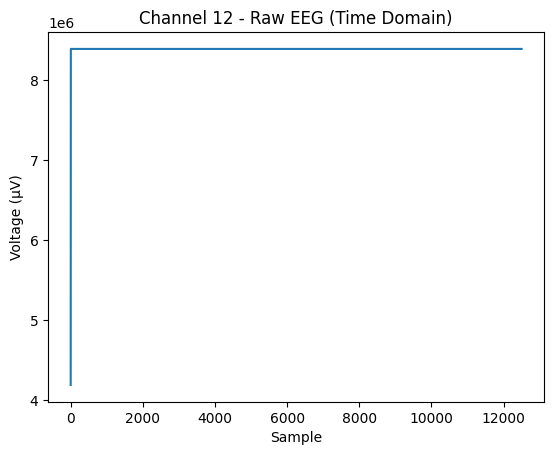

In [3]:
import matplotlib.pyplot as plt

# Plot 5 seconds from channel 0
channel = 12
start, end = 0, 50 * 250  # 5 sec at 250Hz
plt.plot(up_channels.iloc[start:end, channel])
plt.title(f"Channel {channel} - Raw EEG (Time Domain)")
plt.xlabel("Sample")
plt.ylabel("Voltage (µV)")
plt.show()

In [4]:
print(up_channels.describe())

                Ch1           Ch2           Ch3           Ch4            Ch5  \
count  2.383200e+04  2.383200e+04  2.383200e+04  2.383200e+04   23832.000000   
mean   1.230626e+06  1.393202e+06 -2.200937e+06 -1.883327e+06 -252174.710599   
std    1.400413e+05  8.719607e+04  6.140255e+04  1.137552e+05   49951.519233   
min    2.593740e+05  8.318470e+05 -2.480225e+06 -2.259043e+06 -503020.000000   
25%    1.187840e+06  1.369454e+06 -2.240287e+06 -1.975101e+06 -288227.000000   
50%    1.238940e+06  1.389627e+06 -2.191913e+06 -1.869068e+06 -245426.500000   
75%    1.283022e+06  1.414399e+06 -2.151683e+06 -1.783070e+06 -208223.000000   
max    2.120011e+06  2.054241e+06 -1.247706e+06 -1.134828e+06  -95851.000000   

                 Ch6           Ch7           Ch8            Ch9          Ch10  \
count   23832.000000  2.383200e+04  2.383200e+04   23832.000000  2.383200e+04   
mean   -92953.840257 -8.271205e+06  7.922900e+05 -306823.464753  8.388431e+06   
std     18141.746353  9.295873e+05  

### Power Spectral Density (PSD) Analysis

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import welch

def plot_psd(df):
  fs = 250
  eeg_data = df.iloc[:, :16]

  plt.figure(figsize=(10, 6))
  for ch in range(eeg_data.shape[1]):
      f, Pxx = welch(eeg_data.iloc[:, ch].values, fs=fs, nperseg=512)
      plt.semilogy(f, Pxx, label=f"Ch {ch}")

  plt.title("Power Spectral Density (All 16 Channels)")
  plt.xlabel("Frequency (Hz)")
  plt.ylabel("Power Spectral Density")
  plt.xlim(0, 50)  # EEG relevant range
  plt.grid(True)
  plt.legend(ncol=4, fontsize=8)
  plt.tight_layout()
  plt.show()


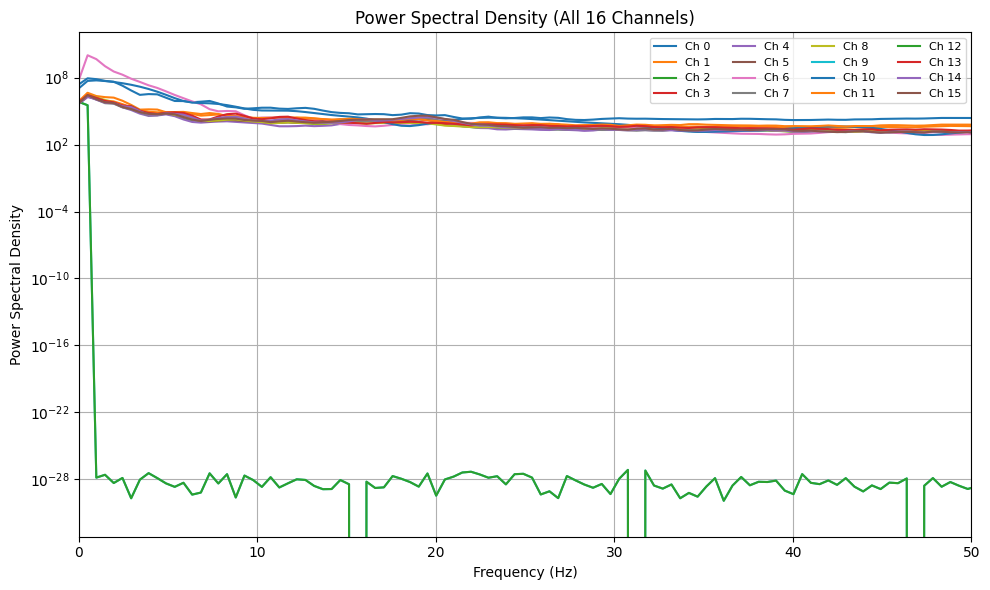

In [6]:
# Left channels

left_channels = pd.read_csv("/content/drive/MyDrive/OpenBCI/left/left_2025-07-30_17:57:49.csv")
plot_psd(left_channels)

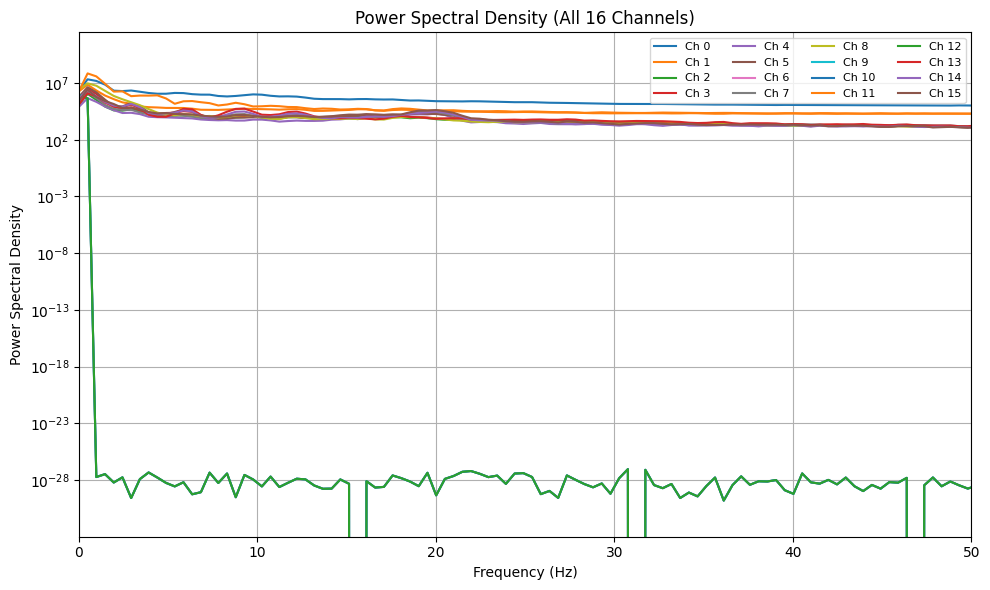

In [7]:
# Right channels

right_channels = pd.read_csv("/content/drive/MyDrive/OpenBCI/right/right_2025-07-30_18:01:33.csv")
plot_psd(right_channels)

In [8]:
SAMPLING_RATE = 250
WINDOW_SIZE = SAMPLING_RATE * 1
STRIDE = SAMPLING_RATE // 2
BANDPASS_LOW = 1
BANDPASS_HIGH = 40

In [9]:
def bandpass_filter(data, low, high, fs):
    b, a = butter(N=4, Wn=[low / (fs/2), high / (fs/2)], btype='band')
    return filtfilt(b, a, data, axis=0)

def segment_windows(data, window_size, stride):
    windows = []
    for start in range(0, data.shape[0] - window_size + 1, stride):
        end = start + window_size
        windows.append(data[start:end])
    return np.stack(windows)

def preprocess_file(file_path, label):
    df = pd.read_csv(file_path)
    eeg_data = df.iloc[:, :16].drop(df.columns[11], axis=1).values

    filtered = bandpass_filter(eeg_data, BANDPASS_LOW, BANDPASS_HIGH, SAMPLING_RATE)

    scaler = StandardScaler()
    normalized = scaler.fit_transform(filtered)

    windows = segment_windows(normalized, WINDOW_SIZE, STRIDE)
    labels = np.full((len(windows),), label)

    return windows, labels

task_to_label = {'left': 0, 'right': 1, 'up': 2, 'down': 3}

def process_dataset(data_dir):
    all_X, all_y = [], []
    for task in os.listdir(data_dir):
      for file in os.listdir(data_dir + "/" + task):
        if file.endswith('.csv'):
            file_path = os.path.join(data_dir, task, file)
            label = task_to_label[task]
            X, y = preprocess_file(file_path, label)
            all_X.append(X)
            all_y.append(y)

    X = np.concatenate(all_X, axis=0)
    y = np.concatenate(all_y, axis=0)
    return X, y

In [10]:
data_dir = '/content/drive/MyDrive/OpenBCI'
X, y = process_dataset(data_dir)

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Shape of X: (3823, 250, 15)
Shape of y: (3823,)


In [37]:
class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx].T, self.y[idx]

In [38]:
class SimpleEEGNet(nn.Module):
    def __init__(self, num_classes=4):
        super(SimpleEEGNet, self).__init__()
        self.net = nn.Sequential(
            nn.Conv1d(15, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),

            nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),

            nn.Flatten(),
            nn.Linear(64 * 62, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.net(x)

In [39]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=42)

train_dataset = EEGDataset(X_train, y_train)
val_dataset = EEGDataset(X_val, y_val)
test_dataset = EEGDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [43]:
model = SimpleEEGNet(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(35):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1} - Loss: {total_loss:.4f}")

Epoch 1 - Loss: 88.4062
Epoch 2 - Loss: 50.7859
Epoch 3 - Loss: 35.3504
Epoch 4 - Loss: 23.8027
Epoch 5 - Loss: 17.9314
Epoch 6 - Loss: 15.8807
Epoch 7 - Loss: 13.6635
Epoch 8 - Loss: 18.6697
Epoch 9 - Loss: 10.2664
Epoch 10 - Loss: 7.9061
Epoch 11 - Loss: 9.3646
Epoch 12 - Loss: 4.9343
Epoch 13 - Loss: 3.5737
Epoch 14 - Loss: 2.9619
Epoch 15 - Loss: 3.0368
Epoch 16 - Loss: 5.1967
Epoch 17 - Loss: 1.8568
Epoch 18 - Loss: 1.7397
Epoch 19 - Loss: 2.0236
Epoch 20 - Loss: 3.1939
Epoch 21 - Loss: 2.8115
Epoch 22 - Loss: 1.7080
Epoch 23 - Loss: 0.5072
Epoch 24 - Loss: 0.3499
Epoch 25 - Loss: 0.2630
Epoch 26 - Loss: 0.1723
Epoch 27 - Loss: 0.1468
Epoch 28 - Loss: 0.1265
Epoch 29 - Loss: 0.1064
Epoch 30 - Loss: 0.1025
Epoch 31 - Loss: 0.0900
Epoch 32 - Loss: 0.0778
Epoch 33 - Loss: 0.0713


KeyboardInterrupt: 

In [44]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(batch_y.numpy())

acc = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {acc:.2%}")

Test Accuracy: 95.16%


In [45]:
torch.save({
    'model_state_dict': model.state_dict(),
    'input_size': 15,
    'hidden_size': 64,
    'num_layers': 2,
    'num_classes': 4
}, "simple_eeg_model.pth")

# LSTM

In [18]:
class EEG_LSTM(nn.Module):
    def __init__(self, input_size=16, hidden_size=64, num_layers=2, num_classes=4):
        super(EEG_LSTM, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=False
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)


In [19]:
class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [20]:
def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, device, epochs=15):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X = batch_X.to(device)
            outputs = model(batch_X)
            pred = torch.argmax(outputs, dim=1).cpu().numpy()
            preds.extend(pred)
            labels.extend(batch_y.numpy())
    return accuracy_score(labels, preds)

In [21]:
def cross_validate(X, y, device, param_grid, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    best_score = 0
    best_params = None

    for params in itertools.product(*param_grid.values()):
        param_dict = dict(zip(param_grid.keys(), params))
        scores = []

        for train_idx, val_idx in kf.split(X):
            train_data = EEGDataset(X[train_idx], y[train_idx])
            val_data = EEGDataset(X[val_idx], y[val_idx])
            train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
            val_loader = DataLoader(val_data, batch_size=32)

            model = EEG_LSTM(
                input_size=15,
                hidden_size=param_dict['hidden_size'],
                num_layers=param_dict['num_layers'],
                num_classes=4
            )

            criterion = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=param_dict['lr'])

            acc = train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, device)
            scores.append(acc)

        avg_score = np.mean(scores)
        print(f"Params: {param_dict} | Avg Val Accuracy: {avg_score:.4f}")
        if avg_score > best_score:
            best_score = avg_score
            best_params = param_dict

    print(f"\nBest Params: {best_params} | Best Accuracy: {best_score:.4f}")
    return best_params

In [22]:
# cross validation to find best param

param_grid = {
    'hidden_size': [16, 32, 64],
    'num_layers': [1, 2],
    'lr': [0.001, 0.004, 0.08]
}

best_params = cross_validate(X_trainval, y_trainval, device, param_grid, n_splits=5)

Params: {'hidden_size': 16, 'num_layers': 1, 'lr': 0.001} | Avg Val Accuracy: 0.5356
Params: {'hidden_size': 16, 'num_layers': 1, 'lr': 0.004} | Avg Val Accuracy: 0.6586
Params: {'hidden_size': 16, 'num_layers': 1, 'lr': 0.08} | Avg Val Accuracy: 0.5588
Params: {'hidden_size': 32, 'num_layers': 1, 'lr': 0.001} | Avg Val Accuracy: 0.5922
Params: {'hidden_size': 32, 'num_layers': 1, 'lr': 0.004} | Avg Val Accuracy: 0.5982
Params: {'hidden_size': 32, 'num_layers': 1, 'lr': 0.08} | Avg Val Accuracy: 0.4026
Params: {'hidden_size': 64, 'num_layers': 1, 'lr': 0.001} | Avg Val Accuracy: 0.5245
Params: {'hidden_size': 64, 'num_layers': 1, 'lr': 0.004} | Avg Val Accuracy: 0.5510
Params: {'hidden_size': 64, 'num_layers': 1, 'lr': 0.08} | Avg Val Accuracy: 0.2861

Best Params: {'hidden_size': 16, 'num_layers': 1, 'lr': 0.004} | Best Accuracy: 0.6586


In [23]:
train_data = EEGDataset(X_train, y_train)
test_data = EEGDataset(X_test, y_test)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)

In [24]:
model = EEG_LSTM(input_size=15, hidden_size=16, num_layers=1).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.004)

In [25]:
train_losses = []

for epoch in range(200):
    model.train()
    running_train_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    train_losses.append(running_train_loss)
    if epoch % 5 == 0:
      print(f"Epoch {epoch+1:02d} | Train Loss: {running_train_loss:.4f}")

Epoch 01 | Train Loss: 102.7278
Epoch 06 | Train Loss: 56.9108
Epoch 11 | Train Loss: 51.8076
Epoch 16 | Train Loss: 37.9260
Epoch 21 | Train Loss: 39.2777
Epoch 26 | Train Loss: 73.5696
Epoch 31 | Train Loss: 49.3713
Epoch 36 | Train Loss: 36.2187
Epoch 41 | Train Loss: 20.7898
Epoch 46 | Train Loss: 20.2755
Epoch 51 | Train Loss: 15.3547
Epoch 56 | Train Loss: 16.9012
Epoch 61 | Train Loss: 14.4883
Epoch 66 | Train Loss: 32.2381
Epoch 71 | Train Loss: 13.6523
Epoch 76 | Train Loss: 30.0152
Epoch 81 | Train Loss: 22.7363
Epoch 86 | Train Loss: 22.8159
Epoch 91 | Train Loss: 12.9536
Epoch 96 | Train Loss: 13.9537
Epoch 101 | Train Loss: 17.9211
Epoch 106 | Train Loss: 15.4715
Epoch 111 | Train Loss: 10.2699
Epoch 116 | Train Loss: 11.7091
Epoch 121 | Train Loss: 12.1378
Epoch 126 | Train Loss: 9.8973
Epoch 131 | Train Loss: 15.7873
Epoch 136 | Train Loss: 12.2916
Epoch 141 | Train Loss: 11.6433
Epoch 146 | Train Loss: 8.0101
Epoch 151 | Train Loss: 8.5399
Epoch 156 | Train Loss: 10.413

In [26]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(batch_y.numpy())

acc = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {acc:.2%}")

Test Accuracy: 87.19%


# GRU

In [27]:
class EEG_GRU(nn.Module):
    def __init__(self, input_size=16, hidden_size=64, num_layers=2, num_classes=4, dropout=0.3):
        super(EEG_GRU, self).__init__()
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True,
            bidirectional=False
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]
        return self.fc(out)


In [28]:
def random_search(X, y, device, search_space, num_trials=10, k_folds=3):
    best_score = 0
    best_params = None
    all_results = []

    for trial in range(num_trials):
        params = {
            'hidden_size': random.choice(search_space['hidden_size']),
            'num_layers': random.choice(search_space['num_layers']),
            'lr': random.choice(search_space['lr']),
            'dropout': random.choice(search_space['dropout'])
        }

        fold_accuracies = []
        kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

        for train_idx, val_idx in kf.split(X):
            train_data = EEGDataset(X[train_idx], y[train_idx])
            val_data = EEGDataset(X[val_idx], y[val_idx])
            train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
            val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

            model = EEG_GRU(
                input_size=15,
                hidden_size=params['hidden_size'],
                num_layers=params['num_layers'],
                dropout=params['dropout'],
                num_classes=4
            )

            criterion = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])

            acc = train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, device)
            fold_accuracies.append(acc)

        avg_acc = np.mean(fold_accuracies)
        all_results.append((params, avg_acc))

        print(f"[Trial {trial+1}] Params: {params} | Avg Accuracy: {avg_acc:.4f}")

        if avg_acc > best_score:
            best_score = avg_acc
            best_params = params

    print(f"\nBest Params: {best_params} | Best Accuracy: {best_score:.4f}")
    return best_params, all_results

In [29]:
search_space = {
    'hidden_size': [32, 64, 128, 256],
    'num_layers': [2, 3, 4],
    'lr': [0.003, 0.002],
    'dropout': [0.2, 0.3]
}

best_params, results = random_search(X, y, device, search_space, num_trials=10, k_folds=3)


[Trial 1] Params: {'hidden_size': 32, 'num_layers': 3, 'lr': 0.002, 'dropout': 0.2} | Avg Accuracy: 0.8470
[Trial 2] Params: {'hidden_size': 128, 'num_layers': 4, 'lr': 0.002, 'dropout': 0.3} | Avg Accuracy: 0.7981
[Trial 3] Params: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.003, 'dropout': 0.3} | Avg Accuracy: 0.7389
[Trial 4] Params: {'hidden_size': 128, 'num_layers': 4, 'lr': 0.003, 'dropout': 0.3} | Avg Accuracy: 0.8093
[Trial 5] Params: {'hidden_size': 32, 'num_layers': 4, 'lr': 0.003, 'dropout': 0.2} | Avg Accuracy: 0.8768
[Trial 6] Params: {'hidden_size': 32, 'num_layers': 3, 'lr': 0.003, 'dropout': 0.2} | Avg Accuracy: 0.8967
[Trial 7] Params: {'hidden_size': 64, 'num_layers': 3, 'lr': 0.003, 'dropout': 0.2} | Avg Accuracy: 0.7721
[Trial 8] Params: {'hidden_size': 128, 'num_layers': 3, 'lr': 0.003, 'dropout': 0.2} | Avg Accuracy: 0.9490
[Trial 9] Params: {'hidden_size': 256, 'num_layers': 3, 'lr': 0.003, 'dropout': 0.3} | Avg Accuracy: 0.6336
[Trial 10] Params: {'hidden_size

In [33]:
model = EEG_GRU(input_size=15, hidden_size=128, num_layers=3, num_classes=4, dropout=0.2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

In [34]:
train_losses = []

for epoch in range(50):
    model.train()
    running_train_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    train_losses.append(running_train_loss)
    if epoch % 5 == 0:
      print(f"Epoch {epoch+1:02d} | Train Loss: {running_train_loss:.4f}")

Epoch 01 | Train Loss: 99.7374
Epoch 06 | Train Loss: 41.2869
Epoch 11 | Train Loss: 13.7447
Epoch 16 | Train Loss: 3.9680
Epoch 21 | Train Loss: 3.3781
Epoch 26 | Train Loss: 5.0092
Epoch 31 | Train Loss: 3.7267
Epoch 36 | Train Loss: 0.0341
Epoch 41 | Train Loss: 0.0122
Epoch 46 | Train Loss: 0.0106


In [35]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(batch_y.numpy())

acc = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {acc:.2%}")

Test Accuracy: 96.99%


In [36]:
torch.save({
    'model_state_dict': model.state_dict(),
    'input_size': 15,
    'hidden_size': 64,
    'num_layers': 2,
    'num_classes': 4
}, "eeg_gru_checkpoint.pth")

## Inference

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from scipy.signal import butter, filtfilt
from sklearn.preprocessing import StandardScaler

SAMPLING_RATE = 250
BANDPASS_LOW = 1
BANDPASS_HIGH = 40

def bandpass_filter(data, low, high, fs):
    b, a = butter(N=4, Wn=[low / (fs / 2), high / (fs / 2)], btype='band')
    return filtfilt(b, a, data, axis=0)

def preprocess_live_eeg(raw_window):
    """
    raw_window: np.array of shape (250, 16)
    returns: processed_window of shape (250, 15)
    """
    assert raw_window.shape == (250, 16), "Expected raw EEG shape (250, 16)"

    raw_window = np.delete(raw_window, 11, axis=1)  # → (250, 15)

    filtered = bandpass_filter(raw_window, BANDPASS_LOW, BANDPASS_HIGH, SAMPLING_RATE)

    scaler = StandardScaler()
    normalized = scaler.fit_transform(filtered)

    return normalized


In [ ]:
class EEG_GRU(nn.Module):
    def __init__(self, input_size=15, hidden_size=64, num_layers=2, num_classes=4, dropout=0.3):
        super(EEG_GRU, self).__init__()
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]
        return self.fc(out)

In [ ]:
class SimpleEEGNet(nn.Module):
    def __init__(self, num_classes=4):
        super(SimpleEEGNet, self).__init__()
        self.net = nn.Sequential(
            nn.Conv1d(15, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),

            nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),

            nn.Flatten(),
            nn.Linear(64 * 62, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
# replace EEG_GRU with SimpleEEGNet class if you want to use SimpleEEG Model
# update the model path as well
def inference(raw_eeg_window: np.ndarray, model_path="eeg_gru_model.pth"):
    processed = preprocess_live_eeg(raw_eeg_window)  # (250, 15)

    model = EEG_GRU()
    model.load_state_dict(torch.load(model_path, map_location='cpu'))
    model.eval()

    with torch.no_grad():
        x = torch.tensor(processed, dtype=torch.float32).unsqueeze(0)  # (1, 250, 15)
        output = model(x)
        pred = torch.argmax(output, dim=1).item()

    return pred
